## Visualization

In [221]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import Tuple, Optional
from dataclasses import dataclass
from enum import Enum
from matplotlib.animation import FuncAnimation


@dataclass
class MatplotlibVizConfig:
    # config for scientific visualization with matplotlib and save as svg
    figsize: Tuple[int, int] = (10, 10)
    dpi: int = 300
    background_color: str = "white"
    font_size: int = 20
    font_family: str = "Arial"
    font_color: str = "black"
    linewidth: int = 2  
    show_grid: bool = True
    use_tex: bool = True
    legend_loc: str = "upper right"
    title: str = ""
    hide_empty_plots: bool = True

    


class PlotOn(Enum):
    APPEND_RIGHT = "append_right"
    APPEND_DOWN = "append_down"
    RIGHT = "right"


class PlotType(Enum):
    LINE = "line"
    SCATTER = "scatter"
    BAR = "bar"
    HIST = "hist"
    IMAGE = "image"


@dataclass
class Plot:
    X: np.ndarray
    y: Optional[np.ndarray]
    plot_type: PlotType
    plot_order: PlotOn
    plot_row_col: Tuple[int, int] = (-1, -1)
    title: str = ""
    title_size: int = 5
    xlabel: str = ""
    ylabel: str = ""
    label_size: int = 5
    color: str = "blue"
    marker: Optional[str] = None
    linestyle: str = "--"
    linewidth: int = 2
    legend: str = ""
    show_legend: bool = True
    legend_size: int = 5
    top_margin: float = 0.9
    bottom_margin: float = 0.1
    left_margin: float = 0.1
    right_margin: float = 0.9
    xmax: Optional[float] = None
    xmin: Optional[float] = None
    ymax: Optional[float] = None
    ymin: Optional[float] = None
    



class MatplotlibVisualizer:
    def __init__(self, config: MatplotlibVizConfig):
        self.config = config
        self._plots = []
        self.curr_row = 0
        self.curr_col = 0
        self.num_rows=1
        self.num_cols=1
        self.num_plots = 0
        self.ax_lim = {}

    def make_figure(self):
        print(f"Making figure with {self.num_rows} rows and {self.num_cols} columns.")        
        fig, ax = plt.subplots(
            self.num_rows,
            self.num_cols,
            figsize=self.config.figsize,
            dpi=self.config.dpi,
            facecolor=self.config.background_color,
            
        )
        fig.suptitle(self.config.title, fontsize=self.config.font_size, fontfamily=self.config.font_family, color=self.config.font_color)
        plt.tight_layout()
        # use latex on text
        if self.config.use_tex:
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
        return fig, np.array(ax).reshape(self.num_rows, self.num_cols)

    def append_plot(
        self,
        plot: Plot,
        left_to_right: bool = True,
    ):
        if self.num_plots == 0:
            self.num_plots += 1
        else:
            if plot.plot_order == PlotOn.APPEND_RIGHT:
                if left_to_right:
                    self.curr_col += 1
            elif plot.plot_order == PlotOn.APPEND_DOWN:
                self.curr_row += 1
                if left_to_right:
                    self.curr_col = 0
            elif plot.plot_order == PlotOn.RIGHT:
                pass
            else:
                raise ValueError("Invalid plot order.")
            self.num_plots += 1
            self.num_rows = max(self.num_rows, self.curr_row + 1)
            self.num_cols = max(self.num_cols, self.curr_col + 1)

        
            
        plot.plot_row_col = (self.curr_row, self.curr_col)

        if plot.X is not None:
            if plot.xmax is None:
                plot.xmax = np.nanmax(plot.X)
            if plot.xmin is None:
                plot.xmin = np.nanmin(plot.X)
            if plot.plot_type == PlotType.IMAGE:
                plot.xmax = plot.X.shape[1]
                plot.xmin = 0
        if plot.y is not None:
            if plot.ymax is None:
                plot.ymax = np.nanmax(plot.y)
            if plot.ymin is None:
                plot.ymin = np.nanmin(plot.y)
        
        # plot.xmax = plot.xmax if not np.isnan(plot.xmax) else 0
        # plot.xmin = plot.xmin if not np.isnan(plot.xmin) else 0
        # plot.ymax = plot.ymax if not np.isnan(plot.ymax) else 0
        # plot.ymin = plot.ymin if not np.isnan(plot.ymin) else 0
        
        self._plots.append(plot)

    def _generate_plot(self, plot: Plot, ax, legend_loc: dict = {}, limit:int=-1):
        curr_row, curr_col = plot.plot_row_col
        key =f'{curr_row}_{curr_col}'
        if plot.plot_type == PlotType.LINE:
            ax.plot(plot.X[:limit], plot.y[:limit], color=plot.color, marker=plot.marker, linestyle=plot.linestyle, linewidth=plot.linewidth)
        elif plot.plot_type == PlotType.SCATTER:
            ax.scatter(plot.X[:limit], plot.y[:limit], color=plot.color, marker=plot.marker, linewidth=plot.linewidth, s=plot.linewidth)
        elif plot.plot_type == PlotType.BAR:
            ax.bar(plot.X[:limit], plot.y[:limit], color=plot.color)
        elif plot.plot_type == PlotType.HIST:
            ax.hist(plot.X[:limit], color=plot.color)
        elif plot.plot_type == PlotType.IMAGE:
            ax.imshow(plot.X)
        else:
            raise ValueError("Invalid plot type.")
        
        # add left margin
        x_min, x_max = plot.xmin, plot.xmax #ax.get_xlim()
        y_min, y_max = plot.ymin, plot.ymax #ax.get_ylim()
        
        if self.ax_lim.get(key) is None:
            self.ax_lim[key] = []
        else:
            x_min = min(x_min, self.ax_lim[key][0])
            x_max = max(x_max, self.ax_lim[key][1])
            y_min = min(y_min, self.ax_lim[key][2])
            y_max = max(y_max, self.ax_lim[key][3])
        self.ax_lim[key]=[x_min, x_max, y_min, y_max]

        ax.set_xlim([x_min - plot.left_margin, x_max + plot.right_margin])
        if plot.y is not None:
            ax.set_ylim([y_min - plot.bottom_margin, y_max + plot.top_margin])
        
        ax.set_title(plot.title, fontsize=plot.title_size, fontfamily=self.config.font_family, color=self.config.font_color)
        ax.set_xlabel(plot.xlabel, fontsize=plot.label_size, fontfamily=self.config.font_family, color=self.config.font_color)
        ax.set_ylabel(plot.ylabel, fontsize=plot.label_size, fontfamily=self.config.font_family, color=self.config.font_color)
        ax.grid(self.config.show_grid)
        if plot.show_legend:
            if plot.legend!='':    
                curr_row, curr_col = plot.plot_row_col
                if legend_loc.get(key) is None:
                    legend_loc[key]=[]
                legend_loc[key].append(plot.legend)
        return ax, legend_loc

    def generate_plots(self):        
        # get figure and axes
        fig, ax = self.make_figure()
        
        legend_loc = {}

       
        for plot in self._plots:
            curr_row, curr_col = plot.plot_row_col            
            # print(f"Generating plot at row {curr_row} and column {curr_col}")
            # return ax, curr_row, curr_col
            curr_ax = ax[curr_row, curr_col]
            
            curr_ax, legend_loc = self._generate_plot(plot, curr_ax, legend_loc)
            
        for rc, loc in legend_loc.items():
            curr_row, curr_col = [int(i) for i in rc.split("_")]
            curr_ax = ax[curr_row, curr_col]
            curr_ax.legend(legend_loc[rc], loc=self.config.legend_loc, fontsize=plot.legend_size)
            
        # hide empty plots
        if self.config.hide_empty_plots:
            plot_row_col = [plot.plot_row_col for plot in self._plots]
            for i in range(self.num_rows):
                for j in range(self.num_cols):
                    if (i, j) not in plot_row_col:
                        ax[i, j].axis("off")


        return fig, ax

    def _animate(self, i, ax, num_frames=30):
        legend_loc = {}

        for plot in self._plots:
            curr_row, curr_col = plot.plot_row_col
            curr_ax = ax[curr_row, curr_col]
            limit = int(i * len(plot.X) / num_frames)

            curr_ax, legend_loc = self._generate_plot(plot, curr_ax, legend_loc, limit=limit)
            
        for rc, loc in legend_loc.items():
            curr_row, curr_col = [int(i) for i in rc.split("_")]
            curr_ax = ax[curr_row, curr_col]
            curr_ax.legend(legend_loc[rc], loc=self.config.legend_loc, fontsize=plot.legend_size)
            
        # hide empty plots
        if self.config.hide_empty_plots:
            plot_row_col = [plot.plot_row_col for plot in self._plots]
            for i in range(self.num_rows):
                for j in range(self.num_cols):
                    if (i, j) not in plot_row_col:
                        ax[i, j].axis("off")
        
        return ax
    
    def animate_plots(self, interval: int = 10, frames: int = 10):
        fig, ax = self.make_figure()
        anim = FuncAnimation(fig, self._animate, frames=frames, fargs=(ax, frames,), interval=interval)
        return anim

    def save_fig(self, fig, path: Path, format: str = "svg"):
        fig.savefig(path, format=format, dpi=self.config.dpi)

    def show_fig(self):
        plt.show()

    def close_fig(self, fig):
        plt.close(fig)
    
    def clear_plots(self):
        plt.clf()
    

Making figure with 3 rows and 2 columns.


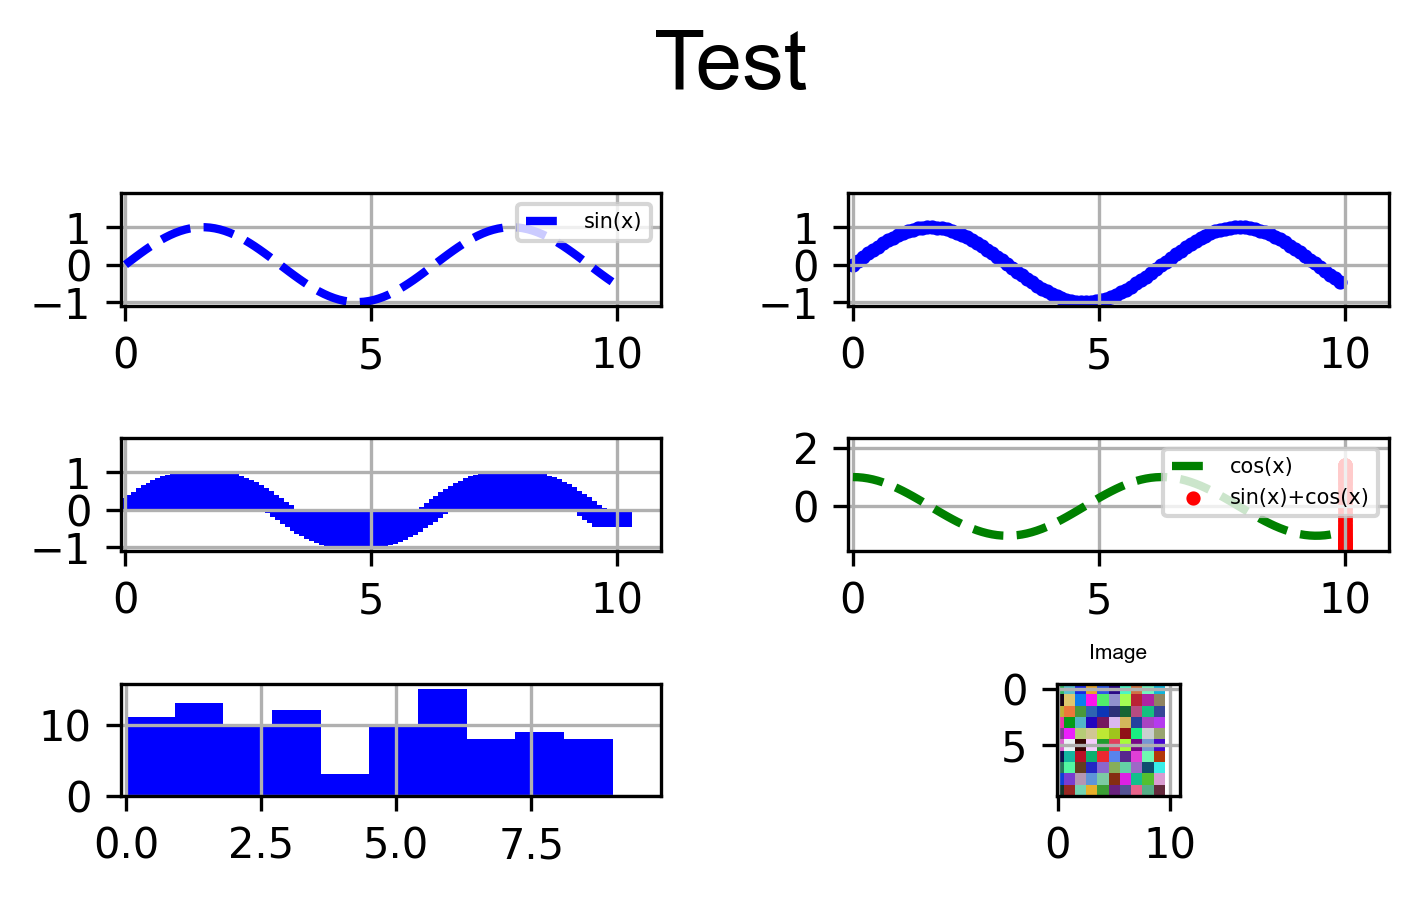

[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]
 [<Axes: > <Axes: title={'center': 'Image'}>]]


In [222]:
viz_config = MatplotlibVizConfig(figsize=(5,3),title="Test",
                                 use_tex=False,)
viz = MatplotlibVisualizer(config=viz_config)

X = np.linspace(0, 10, 100)
y = np.sin(X)
z = np.cos(X)
w = y+z

# show legend in latex format

plot1 = Plot(X=X, y=y, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="sin(x)")
plot2 = Plot(X=X, y=y, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_RIGHT)
plot3 = Plot(X=X, y=y, plot_type=PlotType.BAR, plot_order=PlotOn.APPEND_DOWN)
plot4 = Plot(X=X, y=z, plot_type=PlotType.LINE, plot_order=PlotOn.APPEND_RIGHT, legend="cos(x)", color="green")
plot5 = Plot(X=np.array([1]*100), y=w, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, legend="sin(x)+cos(x)", color="red")
plot5 = Plot(X=np.array([10]*100), y=w, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, legend="", color="red")

plot6 = Plot(X=np.random.randint(0, 10, 100), y=None, plot_type=PlotType.HIST, plot_order=PlotOn.APPEND_DOWN)
plot7 = Plot(X=np.random.randint(0, 255,(10,10, 3)), y=None, plot_type=PlotType.IMAGE, plot_order=PlotOn.APPEND_RIGHT, title="Image")


viz.append_plot(plot1)
viz.append_plot(plot2)
viz.append_plot(plot3)
viz.append_plot(plot4)
viz.append_plot(plot5)
viz.append_plot(plot6)
viz.append_plot(plot7)


fig, ax = viz.generate_plots()
viz.save_fig(fig, Path("expt_res/test.png"), 'png')
viz.show_fig()
viz.close_fig(fig)
print(ax)

MovieWriter imagemagick unavailable; using Pillow instead.


Making figure with 3 rows and 2 columns.


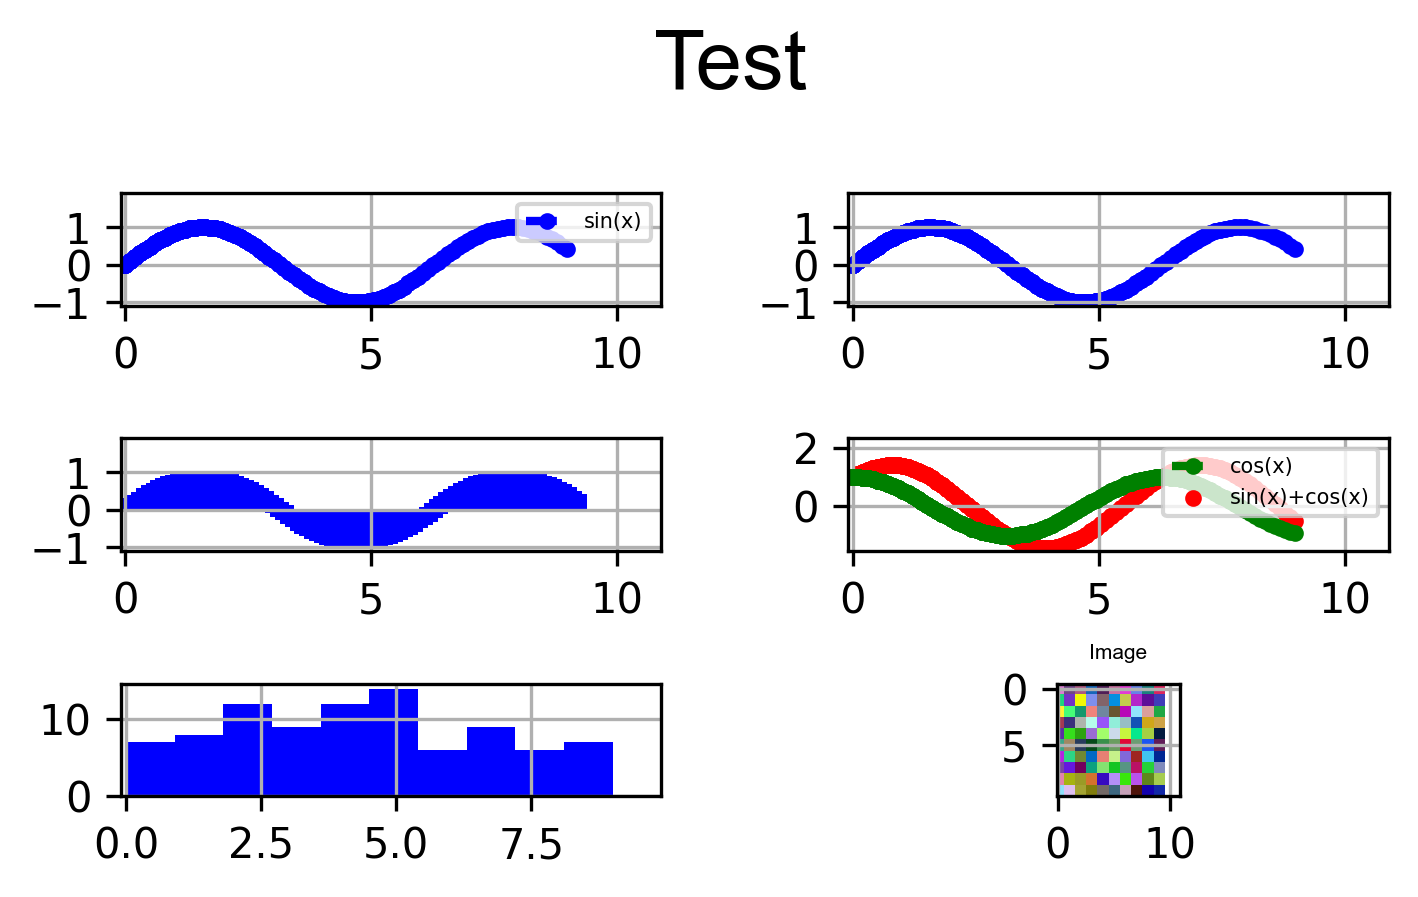

In [3]:
viz.animate_plots().save('expt_res/test.gif', writer='imagemagick', fps=5)

## Loss

In [4]:
from enum import Enum
import numpy as np


class LossType(Enum):
    MSE = "mean_squared_error"
    MAE = "mean_absolute_error"
    HINGE = "hinge"


class Loss:
    def __init__(self, loss_type: LossType):
        self.loss_type = loss_type
        self.name = loss_type.value

    def __call__(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        if self.loss_type == LossType.MSE:
            return self.mean_squared_error(y_true, y_pred)
        elif self.loss_type == LossType.MAE:
            return self.mean_absolute_error(y_true, y_pred)
        elif self.loss_type == LossType.HINGE:
            return self.hinge(y_true, y_pred)
        else:
            raise ValueError(f"Loss type {self.loss_type} not supported")

    def mean_squared_error(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return ((y_true - y_pred) ** 2).mean()

    def mean_absolute_error(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return (y_true - y_pred).abs().mean()

    def hinge(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return (1 - y_true * y_pred).clip(min=0).mean()


## Experiment

In [223]:
import torch.nn as nn
from typing import List
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
import matplotlib.colors as mcolors


class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

@dataclass
class ExperimentConfig:
    name: str
    viz_config: MatplotlibVizConfig
    num_epochs:int
    batch_size:int
    optimizer:str
    model:nn.Module
    loss:Loss
    train_valid_split:float=0.8
    seed:int=100
    metrics:List[Loss]=None

class Runner:
    def __init__(self, name:str, model:nn.Module, batch_size:int, optimizer:str, loss:Loss, 
                 metrics:Optional[List[Loss]]=[], log_every:int=1, log_params:bool=False,
                 is_test:bool=False, data:Dataset=None):
        self.name = name
        self.batch_size = batch_size
        self.metrics = metrics
        self.loss = loss
        self.optimizer = optimizer
        self.model = model
        self.is_test = is_test
        self.data_loader = DataLoader(data, batch_size=64, shuffle=True)
        self.logs = {metric.name:[] for metric in self.metrics}
        self.logs[f"{name}_loss({loss.name})"] = []
        self.logs['weights']=[]
        self.logs['biases']=[]
        self.logs['gradients']=[]
        self.logs['grad_norm']=[]
        self.logs['grad_mean']=[]
        self.logs['grad_std']=[]
        self.logs['epochs']=[]
        self.logs['learning_rate']=[]
        self.curr_epoch = 0
        self.log_every = log_every
        self.log_params = log_params
    
    def step(self):
        if self.is_test:
            self.model.eval()
        else:
            self.model.train()
        
        batch_losses = []
        batch_metrics = {metric.name:[] for metric in self.metrics}

        
        for i, (X, y) in enumerate(self.data_loader):
            self.optimizer.zero_grad()
            y_pred = self.model(X)
            loss = self.loss(y, y_pred)
            batch_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
            for metric in self.metrics:
                batch_metrics[metric.name].append(metric(y, y_pred).detach().numpy())

        if self.curr_epoch % self.log_every == 0:    
            epoch_loss = np.mean(batch_losses)
            epoch_metrics = {metric.name:np.mean(batch_metrics[metric.name]) for metric in self.metrics}
            self.logs[f"{self.name}_loss({self.loss.name})"].append(epoch_loss)
            for metric in self.metrics:
                self.logs[metric.name].append(epoch_metrics[metric.name])
            
            self.logs['epochs'].append(self.curr_epoch)

            if self.log_params:
                self.logs['weights'].append(self.model.weight.data.numpy().copy())
                self.logs['biases'].append(self.model.bias.data.numpy().copy())
                self.logs['gradients'].append(self.model.weight.grad.data.numpy().copy())
                self.logs['grad_norm'].append(np.linalg.norm(self.model.weight.grad.data.numpy().copy()))
                self.logs['grad_mean'].append(np.mean(self.model.weight.grad.data.numpy().copy()))
                self.logs['grad_std'].append(np.std(self.model.weight.grad.data.numpy().copy()))
                self.logs['learning_rate'].append(self.optimizer.param_groups[0]['lr'])
        self.curr_epoch += 1

        return epoch_loss, epoch_metrics
    


class Experiment:
    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.viz_config = config.viz_config
        self.viz = MatplotlibVisualizer(config=self.viz_config)
    
    def setup(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.config.train_valid_split, random_state=self.config.seed)
        train_data = MyDataset(X_train, y_train)
        val_data = MyDataset(X_val, y_val)
        self.train_loader = DataLoader(train_data, batch_size=self.config.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_data, batch_size=self.config.batch_size, shuffle=False)
        self.train_runner = Runner(name="train",loss=self.config.loss, model=self.config.model, batch_size=self.config.batch_size, optimizer=self.config.optimizer, metrics=self.config.metrics, data=train_data, log_params=True)
        self.val_runner = Runner(name="val", loss=self.config.loss,model=self.config.model, batch_size=self.config.batch_size, optimizer=self.config.optimizer, metrics=self.config.metrics, is_test=True, data=val_data)
    
    def train(self):
        try:
            self.train_loader
        except AttributeError:
            raise ValueError("Setup the experiment first.")
        for epoch in range(self.config.num_epochs):
            train_loss, train_metrics = self.train_runner.step()
            val_loss, val_metrics = self.val_runner.step()
            # print(f"Epoch {epoch}: Train Loss: {train_loss}, Val Loss: {val_loss}")
    
    def get_default_plots(self)->List[Plot]:
        plots = []
        colors = mcolors.CSS4_COLORS
        keys = list(colors.keys())
        for metric in self.config.metrics:
            # plot with random matplotlib color
            plot = Plot(X=np.array(self.train_runner.logs['epochs']), y=np.array(self.train_runner.logs[metric.name]), 
                        plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend=f"train_{metric.name}", linestyle="-",
                        marker=None,
                        color=keys[np.random.randint(0, len(keys))])
            plots.append(plot)
        
        

        print(f"Found {len(plots)} metrics to plot.")
        return plots    
    
    def generate_plots(self):
        self.viz.clear_plots()        
        return self.viz.generate_plots()

    def animate_plots(self, interval: int = 10, frames: int = 10):
        return self.viz.animate_plots(interval, frames)
    
    def save_fig(self, fig, path: Path, format: str = "svg"):
        self.viz.save_fig(fig, path, format)
    
    def show_fig(self):
        self.viz.show_fig()
        



X = np.linspace(0, 1000, 1000).reshape(-1, 20)
X = X/X.max()
y = (X.sum(axis=1) + 2).reshape(-1, 1)
print(X.shape, y.shape)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

in_features = X.shape[1]
out_features = y.shape[1]
model = nn.Linear(in_features=in_features, out_features=1)
loss = Loss(LossType.MSE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

viz_config = MatplotlibVizConfig(figsize=(5,3),title="My Exp",
                                 use_tex=False,)
exp_config = ExperimentConfig(name="My Exp", loss=loss, viz_config=viz_config, 
                              num_epochs=100, batch_size=64, optimizer=optimizer, model=model, metrics=[loss, Loss(LossType.MAE)])
exp = Experiment(config=exp_config)
exp.setup(X, y)
exp.train()





(50, 20) (50, 1)


MovieWriter imagemagick unavailable; using Pillow instead.


Found 2 metrics to plot.
Making figure with 1 rows and 1 columns.
Making figure with 1 rows and 1 columns.


<Figure size 640x480 with 0 Axes>

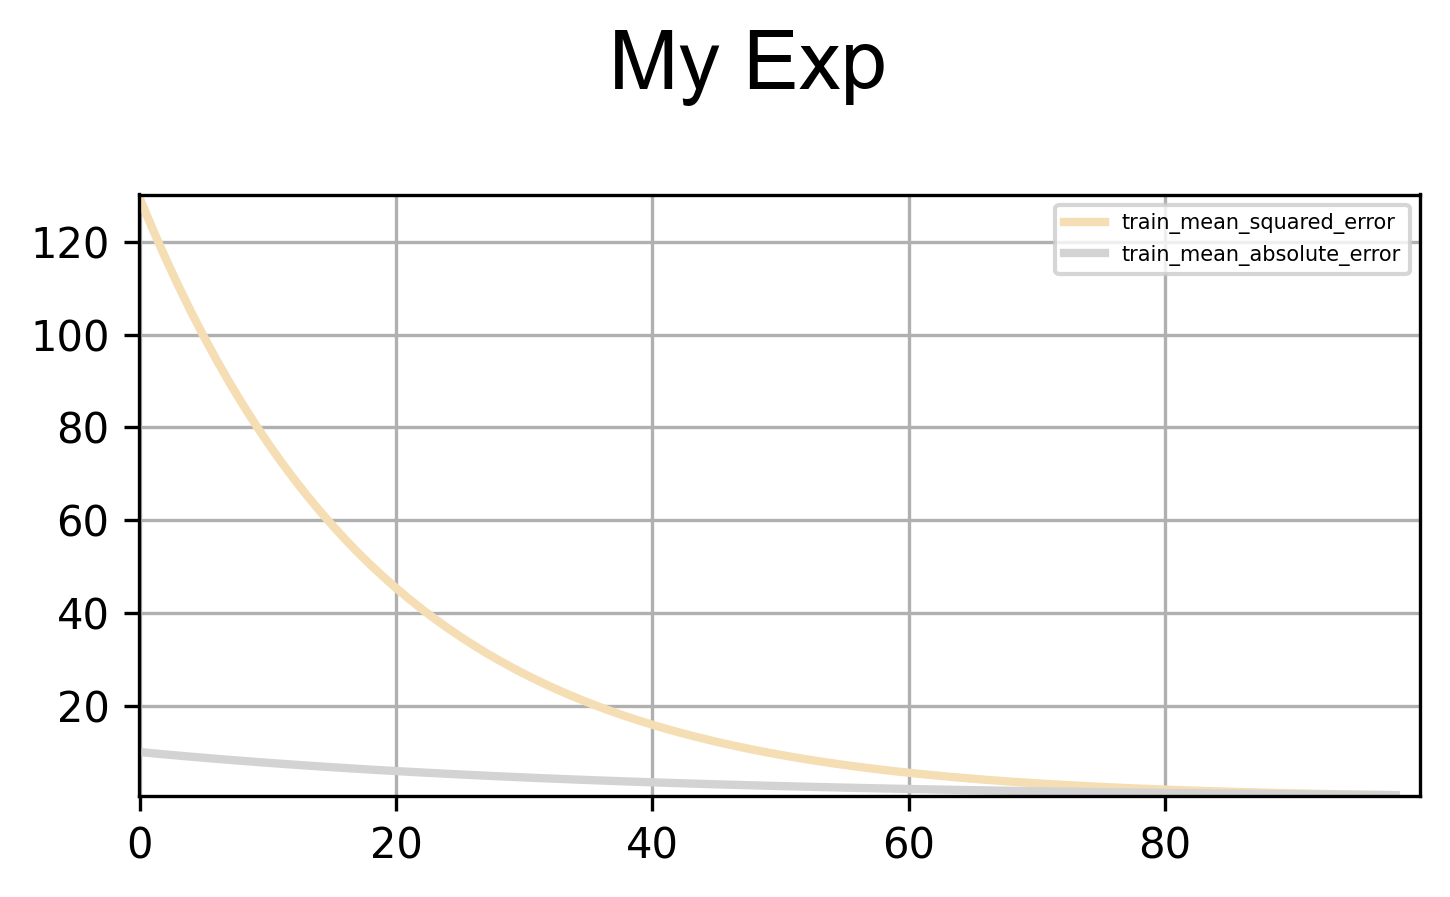

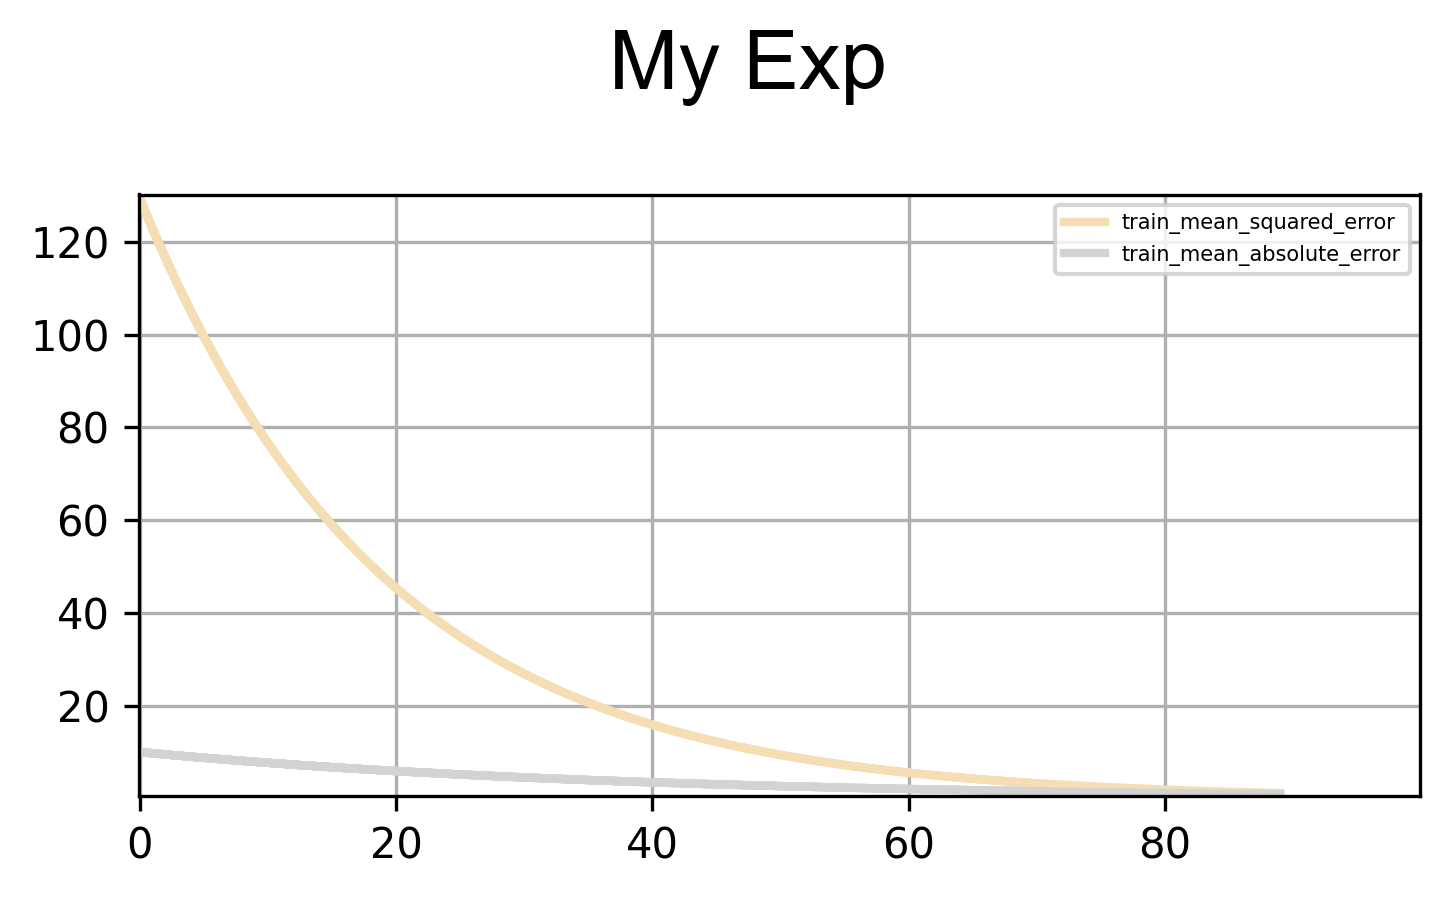

In [224]:
plots = exp.get_default_plots()
exp.viz.clear_plots()
for plot in plots:
    exp.viz.append_plot(plot)
fig, ax = exp.generate_plots()
exp.save_fig(fig, Path("expt_res/test_exp.png"), 'png')
exp.animate_plots().save('expt_res/test_exp.gif', writer='imagemagick', fps=5)

In [227]:
every = 40
plots = []
nviz = MatplotlibVisualizer(config=viz_config)
for i in range(len(exp.train_runner.logs['epochs'])):
    if i%every==0:
        param = exp.train_runner.logs['weights'][i].reshape(-1)
        plot = Plot(X=np.array([i]*len(param)), y=param, 
                    plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, legend="weights", linestyle=".",linewidth=2,
                    marker=None,
                    color='red')
        nviz.append_plot(plot)

    # weights = exp.train_runner.logs['weights'][i]
    # biases = exp.train_runner.logs['biases'][i]
    # gradients = exp.train_runner.logs['gradients'][i]
    # grad_norm = exp.train_runner.logs['grad_norm'][i]
    # grad_mean = exp.train_runner.logs['grad_mean'][i]
    # grad_std = exp.train_runner.logs['grad_std'][i]
    # lr = exp.train_runner.logs['learning_rate'][i]
    # print(f"Epoch {i}: Weights: {weights}, Biases: {biases}, Gradients: {gradients}, Grad Norm: {grad_norm}, Grad Mean: {grad_mean}, Grad Std: {grad_std}, LR: {lr}")


Making figure with 1 rows and 1 columns.


(<Figure size 1500x900 with 1 Axes>, array([[<Axes: >]], dtype=object))

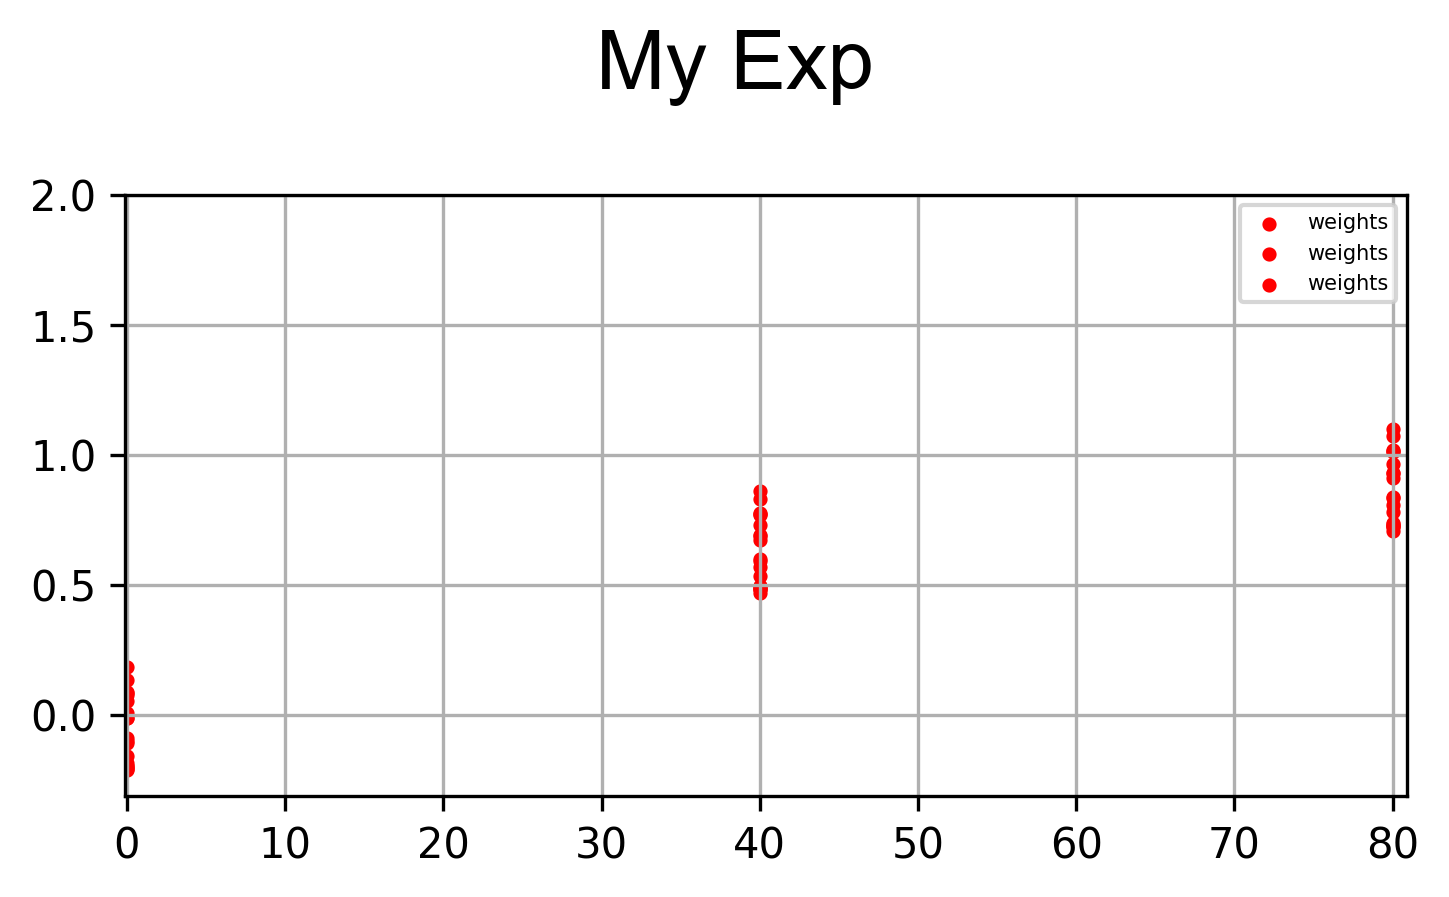

In [228]:
nviz.generate_plots()

array([0.42292333, 0.3145095 , 0.2348819 , 0.18551065, 0.15159522,
       0.03851241, 0.33351418, 0.14657536, 0.38855493, 0.0471428 ,
       0.0547059 , 0.07756799, 0.05275754, 0.25433525, 0.4145379 ,
       0.34477147, 0.41573414, 0.11524889, 0.32908377, 0.3972706 ],
      dtype=float32)

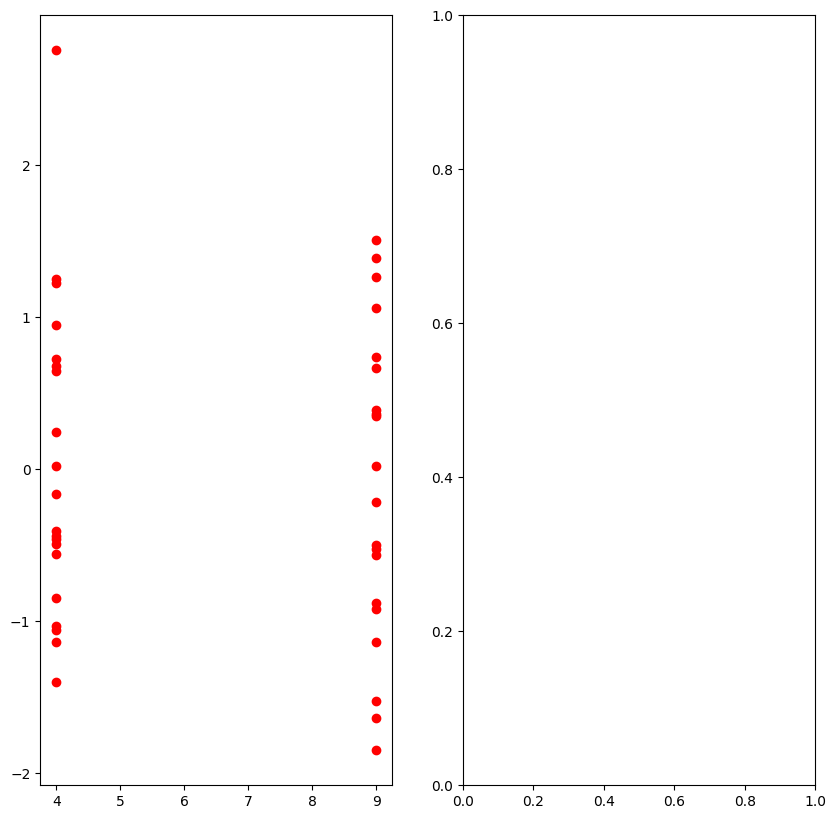

In [204]:
# plt.scatter(exp.train_runner.logs['epochs'], exp.train_runner.logs['grad_norm'], label="grad norm")
# plt.scatter(exp.train_runner.logs['epochs'], exp.train_runner.logs['grad_mean'], label="grad mean")
# plt.scatter(exp.train_runner.logs['epochs'], exp.train_runner.logs['grad_std'], label="grad std")
# plt.scatter(exp.train_runner.logs['epochs'], exp.train_runner.logs['learning_rate'], label="learning rate")

_, ax=plt.subplots(1, 2, figsize=(10, 10))
ax[0].scatter([4]*20, np.random.randn(20), color="red")
ax[0].scatter([9]*20, np.random.randn(20), color="red")